# Time-Series Analysis of Criteria Pollutant Levels 
## Highlighting Lockdown Periods

In [87]:
# required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
import math
import geopandas as gpd
from shapely.geometry import Point, Polygon

from matplotlib import animation, rc
from IPython.display import HTML

from collections import defaultdict

print('Done')

Done


In [2]:
# get list of stations
stations_file = '~/Documents/GitHub/HMEI-2021/stations.csv'

df_stations = pd.read_csv(stations_file)
df_stations.head()

,Full,Spaced,Key,Key2,Key3,Key4
0,"Alipur, Delhi - DPCC",Alipur,Alipur,Alipur,Alipur,Alipur
1,"Anand Vihar, Delhi - DPCC",Anand Vihar,Anand,AnandVihar,AnandVihar,AnandVihar
2,"Ashok Vihar, Delhi - DPCC",Ashok Vihar,Ashok,AshokVihar,AshokVihar,AshokVihar
3,"Aya Nagar, Delhi - IMD",Aya Nagar,Aya,AyaNagar,AyaNagar,AyaNagar
4,"Bawana, Delhi - DPCC",Bawana,Bawana,Bawana,Bawana,Bawana


In [3]:
# refer to stations by preset keys
stations20_21 = [s for s in df_stations['Key3'] if type(s) == str]
stations15_19 = [s for s in df_stations['Key4'] if type(s) == str]

In [4]:
print(len(stations20_21))
print(len(stations15_19))

39
33


# Load hourly data

In [5]:
station_data = {} # dictionary to store each station's data

for station in stations20_21:
    file_str = '~/Documents/GitHub/HMEI-2021/station_data/data_' + station + '.csv'
    df_station = pd.read_csv(file_str)
    
    # set datetime as index
    df_station.index = pd.to_datetime(df_station['From Date'])
    df_station = df_station.drop(columns=['From Date'])

    end_date = pd.to_datetime('2021-05-31 23:00:00')
    df_station = df_station.loc[:end_date]
    
    station_data[station] = {'hourly': df_station}

In [6]:
for station in station_data:
    print(station_data[station]['hourly'].shape)

(56232, 5)
(56232, 5)
(56232, 5)
(56232, 4)
(56232, 5)
(12408, 5)
(56232, 4)
(56232, 5)
(56232, 5)
(12408, 2)
(56232, 4)
(12408, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(12408, 5)
(12408, 5)
(56232, 4)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 4)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(12408, 4)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)
(56232, 5)


# Add dataframes of various timesteps to each station's dictionary

In [7]:
# return mean of array with the condition that at least 1 non-NaN value must be present
# if condition is not satisfied, return NaN
def at_least_one(array):
    elems = []
    for elem in array:
        if not math.isnan(elem):
            elems.append(elem)
    if len(elems) >= 1:
        return sum(elems) / len(elems)
    else:
        return math.nan

In [8]:
# return mean of array with the condition that at least 2 non-NaN values must be present
# if condition is not satisfied, return NaN
def at_least_two(array):
    elems = []
    for elem in array:
        if not math.isnan(elem):
            elems.append(elem)
    if len(elems) >= 2:
        return sum(elems) / len(elems)
    else:
        return math.nan

In [9]:
# return mean of array with the condition that at least 8 non-NaN values must be present
# if condition is not satisfied, return NaN
def at_least_eight(array):
    elems = []
    for elem in array:
        if not math.isnan(elem):
            elems.append(elem)
    if len(elems) >= 8:
        return sum(elems) / len(elems)
    else:
        return math.nan

In [10]:
# get the MDA8 ozone value for a 24-hour period
def MDA8_Ozone(array):
    max_avg = None
    i = 0
    while i + 8 <= len(array):
        elems = []
        for j in range(i, i+8):
            if not math.isnan(array[j]):
                elems.append(array[j])
        # must include at least 6 hourly values to get an average
        if len(elems) >= 6:
            avg = sum(elems) / len(elems)
            if (not max_avg) or (avg > max_avg):
                max_avg = avg
        i += 1
    if not max_avg:
        return math.nan
    else:
        return max_avg

In [11]:
for station in station_data:
    try:
        hourly = station_data[station]['hourly']
        diurnal = hourly.loc['2015-01-01 6:00:00':, hourly.columns != 'Ozone'].resample('12H', origin='2015-01-01 6:00:00').apply(at_least_one)
        daily = diurnal.resample('24H', origin='2015-01-01 06:00:00').apply(at_least_two)
        
        if 'Ozone' in hourly.columns:
            mda8_ozone = hourly.loc['2015-01-01 6:00:00':, 'Ozone'].resample('24H', origin='2015-01-01 6:00:00').apply(MDA8_Ozone)
            daily['Ozone'] = mda8_ozone
        
        monthly = daily.resample('M').apply(at_least_eight)
        monthly = monthly.rename_axis(index='To Date')
        
        # add to dictionary
        station_data[station]['diurnal'] = diurnal 
        station_data[station]['daily'] = daily
        station_data[station]['monthly'] = monthly
        
    except Exception as e:
        print(e, station)

In [12]:
# get seasonal averages
for station in station_data:
    monthly = station_data[station]['monthly']

    seasonal = pd.DataFrame(index=['DJF2015', 'MAM2015', 'JJA2015', 'SON2015', 
                                   'DJF2016', 'MAM2016', 'JJA2016', 'SON2016',
                                   'DJF2017', 'MAM2017', 'JJA2017', 'SON2017',
                                   'DJF2018', 'MAM2018', 'JJA2018', 'SON2018',
                                   'DJF2019', 'MAM2019', 'JJA2019', 'SON2019',
                                   'DJF2020', 'MAM2020', 'JJA2020', 'SON2020',
                                   'DJF2021', 'MAM2021'],
                                    columns=monthly.columns)

    DJF_2015 = monthly.loc['2015-01':'2015-02']
    for col in DJF_2015.columns:
        seasonal.loc['DJF2015', col] = at_least_one(DJF_2015[col])

    for year in range(2016, 2022):
        date_start = str(year - 1) + '-12'
        date_end = str(year) + '-02'
        row = 'DJF' + str(year)
        DJF = monthly.loc[date_start:date_end]
        for col in DJF.columns:
            seasonal.loc[row, col] = at_least_one(DJF[col])

    for year in range(2015, 2022):
        date_start = str(year) + '-03'
        date_end = str(year) + '-05'
        row = 'MAM' + str(year)
        MAM = monthly.loc[date_start:date_end]
        for col in MAM.columns:
            seasonal.loc[row, col] = at_least_one(MAM[col])

    for year in range(2015, 2021):
        date_start = str(year) + '-06'
        date_end = str(year) + '-08'
        row = 'JJA' + str(year)
        JJA = monthly.loc[date_start:date_end]
        for col in JJA.columns:
            seasonal.loc[row, col] = at_least_one(JJA[col])

    for year in range(2015, 2021):
        date_start = str(year) + '-09'
        date_end = str(year) + '-11'
        row = 'SON' + str(year)
        SON = monthly.loc[date_start:date_end]
        for col in SON.columns:
            seasonal.loc[row, col] = at_least_one(SON[col])
            
    station_data[station]['seasonal'] = seasonal

In [13]:
# get yearly averages
for station in station_data:
    seasonal = station_data[station]['seasonal']
    yearly = pd.DataFrame(index=[x for x in range(2015, 2021)], columns=seasonal.columns)

    for year in range(2015, 2021):
        start_date = 'DJF' + str(year)
        end_date = 'SON' + str(year)
        YA = seasonal.loc[start_date:end_date]
        for col in seasonal:
            yearly.loc[year, col] = at_least_one(YA[col])
    
    station_data[station]['yearly'] = yearly

# Spatial analysis

In [14]:
coords = {}
for station in stations15_19:
    file_str = '~/Documents/GitHub/HMEI-2021/Data 2015-19/data_' + station + '.csv'
    r1 = pd.read_csv(file_str, nrows=1)
    coords[station] = (r1['lat'], r1['lon'])

In [15]:
for station in coords:
    print(station)
    print(float(coords[station][0]))
    print(float(coords[station][1]))
    print()

Alipur
28.796635
77.13916

AnandVihar
28.618821
77.010183

AshokVihar
28.485269
77.015767

AyaNagar
28.475084
77.133169

Bawana
28.808334
77.041482

CRRI
28.551242
77.274622

DTU
28.750616
77.116578

Dwarka8
28.565612
77.067064

IGI
28.554842
77.08434

ITO
28.62735
77.243303

Jahangirpuri
28.72562
77.182357

JNStadium
28.69847
77.104687

Lodhi_IMD
28.589444
77.212914

MajorDhyanChand
28.612536
77.237331

MandirMarg
28.574151
77.07731

Mundka
28.681933
77.030648

Najafgarh
28.613304
76.980431

Narela
28.852488
77.097797

NehruNagar
28.570244
77.253286

NorthCampus
28.714833
77.129333

NSITDwarka
28.597807
77.073263

Okhla
28.562572
77.286059

Patparganj
28.6347
77.3046

PunjabiBagh
28.667505
77.127874

Pusa_DPCC
28.64204
77.174999

RKPuram
28.562199
77.172283

Rohini
28.702805
77.096446

Shadipur
28.652243
77.151937

Sirifort
28.551793
77.214456

SoniaVihar
28.71431
77.247719

SriAuro
28.569229
77.207283

VivekVihar
28.66852
77.3167

Wazirpur
28.68929
77.17513



In [254]:
# return distance between two coordinates (in kilometers)
def findDistance(lat1, lat2, lng1, lng2):
    R = 6371
    dLat = (lat2 - lat1) * (math.pi / 180)
    dLng = (lng2 - lng1) * (math.pi / 180)
    a = \
        math.sin(dLat/2) * math.sin(dLat/2) + \
        math.cos(lat1 * (math.pi / 180)) * math.cos(lat2 * (math.pi / 180)) * \
        math.sin(dLng/2) * math.sin(dLng/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    # km_to_mile = 0.621371
    # return d * km_to_mile
    return d

In [245]:
# diagonal distance (in km) of one grid box (0.01 x 0.01 grid units)
findDistance(28, 28.01, 78, 78.01)

1.4833270247528099

In [262]:
findDistance(28, 28.1349, 78, 78.1349)

20.004992003763796

In [261]:
math.sqrt((28-28.1349)**2 + (78-78.1349)**2)

0.19077740956413056

## Function to plot single heat map

In [241]:
# NOTE: Alpha values are not comparable between two separate heat maps plotted with this function,
# as the minimum and maximum pollutant levels for two different maps / time periods will be different.

file_path = 'india_districts/polbnda_ind.shp'
india = gpd.read_file(file_path)

df_stations = pd.DataFrame(index=stations15_19, columns=['lat', 'lon'])
for station in stations15_19:
    df_stations.loc[station, 'lat'] = float(coords[station][0])
    df_stations.loc[station, 'lon'] = float(coords[station][1])

gdf_stations = gpd.GeoDataFrame(df_stations, geometry=gpd.points_from_xy(df_stations.lon, df_stations.lat))

# examples of parameters: 
# timestep: 'seasonal', date: 'MAM2018', pollutant: 'PM2.5'
def plotHeatMap(timestep, date, pollutant):
    
    # set up empty geo-dataframe for heatmap
    latitude = np.arange(28.35, 29, 0.01)
    longitude = np.arange(76.8, 77.45, 0.01)[:-1]
    n = len(latitude)
    geometry = []
    for i in range(n-1):
        for j in range(n-1):
            poly = Polygon([(longitude[i], latitude[j]), (longitude[i], latitude[j+1]),
                            (longitude[i+1], latitude[j+1]), (longitude[i+1], latitude[j])])
            geometry.append(poly)
    heatmap = gpd.GeoDataFrame(geometry=geometry)
    heatmap[pollutant] = None
    
    # iterate over each gridbox
    for i in range(len(heatmap)):
        
        # coordinates of gridbox centroid
        lat1 = heatmap.loc[i, 'geometry'].centroid.y
        lon1 = heatmap.loc[i, 'geometry'].centroid.x
        near_measurements = []
        for station in stations15_19:
            if pollutant in station_data[station][timestep]:
                lat2, lon2 = coords[station]
                distance = math.sqrt((lat1-lat2)**2 + (lon1-lon2)**2)
                # if distance between station and gridbox centroid is < 20 km ~ 0.19 grid units
                if distance < 0.19:
                    near_measurements.append(station_data[station][timestep].loc[date, pollutant])
        # take the average of all stations within 20 km and assign value to current gridbox
        avg = at_least_one(near_measurements)
        heatmap.loc[i, pollutant] = avg
    
    # drop NaN rows
    dropped = []
    for i in range(len(heatmap)):
        if math.isnan(heatmap.loc[i, pollutant]):
            dropped.append(i)
    heatmap = heatmap.drop(dropped)
    
    minimum = min(heatmap[pollutant])
    maximum = max(heatmap[pollutant])
    
    print('Minimum: ' + str(minimum))
    print('Maximum: ' + str(maximum))
    
    fig, ax = plt.subplots(figsize=(10, 10))

    india.boundary.plot(ax=ax)
    heatmap.plot(color='r', alpha=(heatmap[pollutant] - minimum) / (maximum - minimum), ax=ax)
    gdf_stations.plot(marker='o', color='purple', markersize=100, ax=ax, label='Station')
    ax.set_xlim(76.75, 77.5)
    ax.set_ylim(28.30, 29.0)
    ax.set_title('Duration: ' + date + '\nPollutant: ' + pollutant)

    plt.legend()
    
    fig_title = date + '_' + pollutant + '_HeatMap.tiff'
    plt.savefig(fig_title, bbox_inches="tight")
    
    plt.show()

Minimum: 65.6516991262258
Maximum: 102.0967091343097


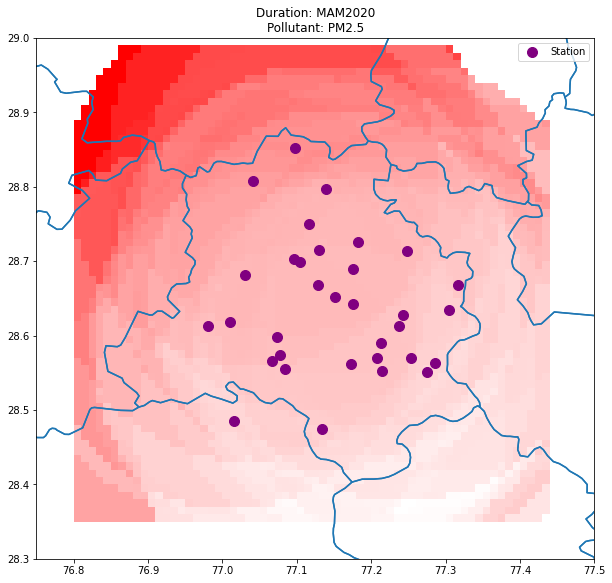

In [239]:
plotHeatMap('seasonal', 'MAM2020', 'PM2.5')

Minimum: 84.67852875243914
Maximum: 118.45525883637745


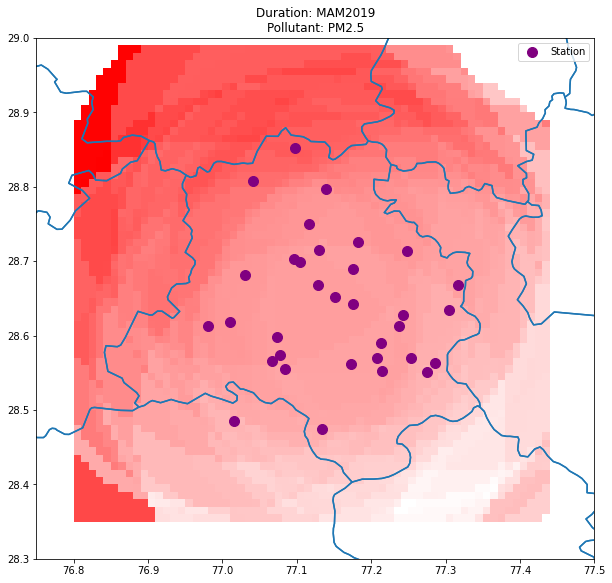

In [231]:
plotHeatMap('seasonal', 'MAM2019', 'PM2.5')

## Function to make heat map geo-dataframe for a set of dates

In [235]:
file_path = 'india_districts/polbnda_ind.shp'
india = gpd.read_file(file_path)

df_stations = pd.DataFrame(index=stations15_19, columns=['lat', 'lon'])
for station in stations15_19:
    df_stations.loc[station, 'lat'] = float(coords[station][0])
    df_stations.loc[station, 'lon'] = float(coords[station][1])

gdf_stations = gpd.GeoDataFrame(df_stations, geometry=gpd.points_from_xy(df_stations.lon, df_stations.lat))

def makeHeatMap(timestep, dates, pollutant):
    
    # set up empty geo-dataframe for heatmap
    latitude = np.arange(28.35, 29, 0.01)
    longitude = np.arange(76.8, 77.45, 0.01)[:-1]
    n = len(latitude)
    geometry = []
    for i in range(n-1):
        for j in range(n-1):
            poly = Polygon([(longitude[i], latitude[j]), (longitude[i], latitude[j+1]),
                            (longitude[i+1], latitude[j+1]), (longitude[i+1], latitude[j])])
            geometry.append(poly)
    heatmap = gpd.GeoDataFrame(geometry=geometry)
    
    # keep track of minimum and maximum gridbox value (across all maps / dates)
    minimum = None
    maximum = None
    
    for date in dates:
        heatmap[date] = None
        for i in range(len(heatmap)):
            lat1 = heatmap.loc[i, 'geometry'].centroid.y
            lon1 = heatmap.loc[i, 'geometry'].centroid.x
            near_measurements = []
            for station in stations15_19:
                if pollutant in station_data[station][timestep].columns:
                    lat2, lon2 = coords[station]
                    distance = math.sqrt((lat1-lat2)**2 + (lon1-lon2)**2)
                    # if distance between station and gridbox centroid is < 20 km ~ 0.19 grid units
                    if distance < 0.19:
                        near_measurements.append(station_data[station][timestep].loc[date, pollutant])
            avg = at_least_one(near_measurements)
            heatmap.loc[i, date] = avg
        minp = np.nanmin(heatmap[date])
        maxp = np.nanmax(heatmap[date])
        if not math.isnan(minp):
            if (minimum == None) or (minp < minimum):
                minimum = minp
        if not math.isnan(maxp):
            if (maximum == None) or (maxp > maximum):
                maximum = maxp
    
    return heatmap, minimum, maximum

$PM_{2.5}$

In [236]:
dates = ['MAM2015', 'MAM2016', 'MAM2017', 'MAM2018', 'MAM2019', 'MAM2020', 'MAM2021']
hm_pm2_5, min_pm2_5, max_pm2_5 = makeHeatMap('seasonal', dates, 'PM2.5')

In [237]:
# record the names of stations present during each year to plot later
dates = ['MAM2015', 'MAM2016', 'MAM2017', 'MAM2018', 'MAM2019', 'MAM2020', 'MAM2021']
absent_stations = defaultdict(list)
for date in dates:
    for station in stations15_19:
        if 'PM2.5' in station_data[station]['seasonal'].columns:
            if math.isnan(station_data[station]['seasonal'].loc[date, 'PM2.5']):
                absent_stations[date].append(station)
        else:
            absent_stations[date].append(station)

In [238]:
# NOTE: Alpha values on the heat maps generated here ARE comparable between separate graphs in the animation,
# as they use the same maximum and minimum values across all time periods.

print('Minimum: ' + str(min_pm2_5))
print('Maximum: ' + str(max_pm2_5))

fig, ax = plt.subplots(figsize=(8, 8))
def animate(i):
    if dates[i] in absent_stations:
        curr_stations = gdf_stations.drop(absent_stations[dates[i]])
    else:
        curr_stations = gdf_stations
    
    dropped = []
    for j in range(len(hm_pm2_5)):
        if math.isnan(hm_pm2_5.loc[j, dates[i]]):
            dropped.append(j)
    curr_hm = hm_pm2_5.drop(dropped)
    
    curr_hm.plot(color='white', ax=ax)
    curr_hm.plot(color='red', alpha=(curr_hm[dates[i]] - min_pm2_5) / (max_pm2_5 - min_pm2_5), ax=ax)
    india.boundary.plot(ax=ax)
    curr_stations.plot(marker='o', color='purple', markersize=80, ax=ax, label='Station')
    ax.set_xlim(76.75, 77.50)
    ax.set_ylim(28.30, 29.05)
    ax.set_title(dates[i])
    
anim = animation.FuncAnimation(fig, animate, frames=len(dates))
plt.close()
HTML(anim.to_jshtml())

Minimum: 65.6516991262258
Maximum: 203.49576325757576


<Figure size 432x288 with 0 Axes>

$PM_{10}$

In [242]:
dates = ['MAM2015', 'MAM2016', 'MAM2017', 'MAM2018', 'MAM2019', 'MAM2020', 'MAM2021']
hm_pm10, min_pm10, max_pm10 = makeHeatMap('seasonal', dates, 'PM10')

In [243]:
# record the names of stations present during each year to plot later
dates = ['MAM2015', 'MAM2016', 'MAM2017', 'MAM2018', 'MAM2019', 'MAM2020', 'MAM2021']
absent_stations = defaultdict(list)
for date in dates:
    for station in stations15_19:
        if 'PM10' in station_data[station]['seasonal'].columns:
            if math.isnan(station_data[station]['seasonal'].loc[date, 'PM10']):
                absent_stations[date].append(station)
        else:
            absent_stations[date].append(station)

In [244]:
# NOTE: Alpha values on the heat maps generated here ARE comparable between separate graphs in the animation,
# as they use the same maximum and minimum values across all time periods.

print('Minimum: ' + str(min_pm10))
print('Maximum: ' + str(max_pm10))

fig, ax = plt.subplots(figsize=(8, 8))
def animate(i):
    if dates[i] in absent_stations:
        curr_stations = gdf_stations.drop(absent_stations[dates[i]])
    else:
        curr_stations = gdf_stations
    
    dropped = []
    for j in range(len(hm_pm10)):
        if math.isnan(hm_pm10.loc[j, dates[i]]):
            dropped.append(j)
    curr_hm = hm_pm10.drop(dropped)
    
    curr_hm.plot(color='white', ax=ax)
    curr_hm.plot(color='red', alpha=(curr_hm[dates[i]] - min_pm10) / (max_pm10 - min_pm10), ax=ax)
    india.boundary.plot(ax=ax)
    curr_stations.plot(marker='o', color='purple', markersize=80, ax=ax, label='Station')
    ax.set_xlim(76.75, 77.50)
    ax.set_ylim(28.30, 29.05)
    ax.set_title(dates[i])
    
anim = animation.FuncAnimation(fig, animate, frames=len(dates))
plt.close()
HTML(anim.to_jshtml())

Minimum: 130.69670650144408
Maximum: 475.8390786357624


<Figure size 432x288 with 0 Axes>

$NO_2$

In [ ]:
dates = ['MAM2015', 'MAM2016', 'MAM2017', 'MAM2018', 'MAM2019', 'MAM2020', 'MAM2021']
hm_NO2, min_NO2, max_NO2 = makeHeatMap('seasonal', dates, 'NO2')

In [ ]:
# record the names of stations present during each year to plot later
dates = ['MAM2015', 'MAM2016', 'MAM2017', 'MAM2018', 'MAM2019', 'MAM2020', 'MAM2021']
absent_stations = defaultdict(list)
for date in dates:
    for station in stations15_19:
        if 'NO2' in station_data[station]['seasonal'].columns:
            if math.isnan(station_data[station]['seasonal'].loc[date, 'NO2']):
                absent_stations[date].append(station)
        else:
            absent_stations[date].append(station)

In [ ]:
# NOTE: Alpha values on the heat maps generated here ARE comparable between separate graphs in the animation,
# as they use the same maximum and minimum values across all time periods.

print('Minimum: ' + str(min_NO2))
print('Maximum: ' + str(max_NO2))

fig, ax = plt.subplots(figsize=(8, 8))
def animate(i):
    if dates[i] in absent_stations:
        curr_stations = gdf_stations.drop(absent_stations[dates[i]])
    else:
        curr_stations = gdf_stations
    
    dropped = []
    for j in range(len(hm_NO2)):
        if math.isnan(hm_NO2.loc[j, dates[i]]):
            dropped.append(j)
    curr_hm = hm_NO2.drop(dropped)
    
    curr_hm.plot(color='white', ax=ax)
    curr_hm.plot(color='red', alpha=(curr_hm[dates[i]] - min_NO2) / (max_NO2 - min_NO2), ax=ax)
    india.boundary.plot(ax=ax)
    curr_stations.plot(marker='o', color='purple', markersize=80, ax=ax, label='Station')
    ax.set_xlim(76.75, 77.50)
    ax.set_ylim(28.30, 29.05)
    ax.set_title(dates[i])
    
anim = animation.FuncAnimation(fig, animate, frames=len(dates))
plt.close()
HTML(anim.to_jshtml())

## Animate monthly variation in $PM_{2.5}$ levels in 2020 

In [210]:
months_2020 = station_data['Alipur']['monthly'].loc['2020'].index
hm_2020, minpm2_5, maxpm2_5 = makeHeatMap('monthly', months_2020, 'PM2.5')

In [195]:
print('Minimum: ' + str(minpm2_5))
print('Maximum: ' + str(maxpm2_5))
months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']

fig, ax = plt.subplots(figsize=(8, 8))
def animate(i):
    if months_2020[i] in absent_stations:
        curr_stations = gdf_stations.drop(absent_stations[months_2020[i]])
    else:
        curr_stations = gdf_stations
    
    dropped = []
    for j in range(len(hm_2020)):
        if math.isnan(hm_2020.loc[j, months_2020[i]]):
            dropped.append(j)
    curr_hm = hm_2020.drop(dropped)
    
    curr_hm.plot(color='white', ax=ax)
    curr_hm.plot(color='red', alpha=(curr_hm[months_2020[i]] - minpm2_5) / (maxpm2_5 - minpm2_5), ax=ax)
    india.boundary.plot(ax=ax)
    curr_stations.plot(marker='o', color='purple', markersize=80, ax=ax, label='Station')
    ax.set_xlim(76.75, 77.50)
    ax.set_ylim(28.30, 29.05)
    ax.set_title(months[i] + ' 2020')
    
anim = animation.FuncAnimation(fig, animate, frames=len(months_2020))
plt.close()
HTML(anim.to_jshtml())

Minimum: 49.62871496769255
Maximum: 191.64761047979798


<Figure size 432x288 with 0 Axes>